# ============================================
#  Reproducibility Setup
# ============================================

In [1]:
import os, sys, random, numpy as np, tensorflow as tf

# Set global seed
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure deterministic ops
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Restrict TensorFlow to one GPU for strict reproducibility
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')  # use only first GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Using only one GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))



2025-08-23 08:49:25.004649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755938965.027365      93 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755938965.034229      93 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using only one GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow: 2.18.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
#pip install -U scikit-learn==1.6.1 imbalanced-learn==0.13.0


# 1. Import Required Libraries
Purpose: Import necessary libraries for preprocessing, modeling, and evaluation.

In [3]:
# General and Data Libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Image Processing
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from imblearn.over_sampling import RandomOverSampler


# Visualization Style
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

# 2. Load Dataset
Purpose: Load metadata and verify dataset structure.

In [4]:
# Load metadata
data = pd.read_csv('/kaggle/input/isic-2019-skin-lesion-images-for-classification/ISIC_2019_Training_GroundTruth.csv')
print("Data Shape:", data.shape)

# Check image folder structure
dataset_path = '/kaggle/input/isic-2019-skin-lesion-images-for-classification/'
print(os.listdir(dataset_path))

Data Shape: (25331, 10)
['MEL', 'VASC', 'SCC', 'DF', 'NV', 'ISIC_2019_Training_GroundTruth.csv', 'ISIC_2019_Training_Metadata.csv', 'BKL', 'BCC', 'AK']


# 3. Image Loading and Preprocessing
## 3.1 Define Image Loader
Purpose: Load and resize images to the required input shape.

In [5]:
def load_and_resize_images(image_paths, target_size=(28, 28)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  # Load and resize
        img_array = img_to_array(img)  # Convert to array
        images.append(img_array)
    return np.array(images)

## 3.2 Load Images by Class
Purpose: Load all images and assign corresponding labels.

In [6]:
# Define classes
class_folders = ['MEL', 'VASC', 'SCC', 'DF', 'NV', 'BKL', 'BCC', 'AK']

# Load images and labels
all_images, all_labels = [], []

for class_name in class_folders:
    class_folder_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_folder_path)
    class_images = load_and_resize_images([os.path.join(class_folder_path, img) for img in image_files])
    all_images.append(class_images)
    all_labels.append([class_name] * len(image_files))

# Combine all data
X_all = np.concatenate(all_images, axis=0)
y_all = np.concatenate(all_labels, axis=0)

print("Shape of all images:", X_all.shape)
print("Shape of all labels:", y_all.shape)

Shape of all images: (25331, 28, 28, 3)
Shape of all labels: (25331,)


## Sample Images from Each Class

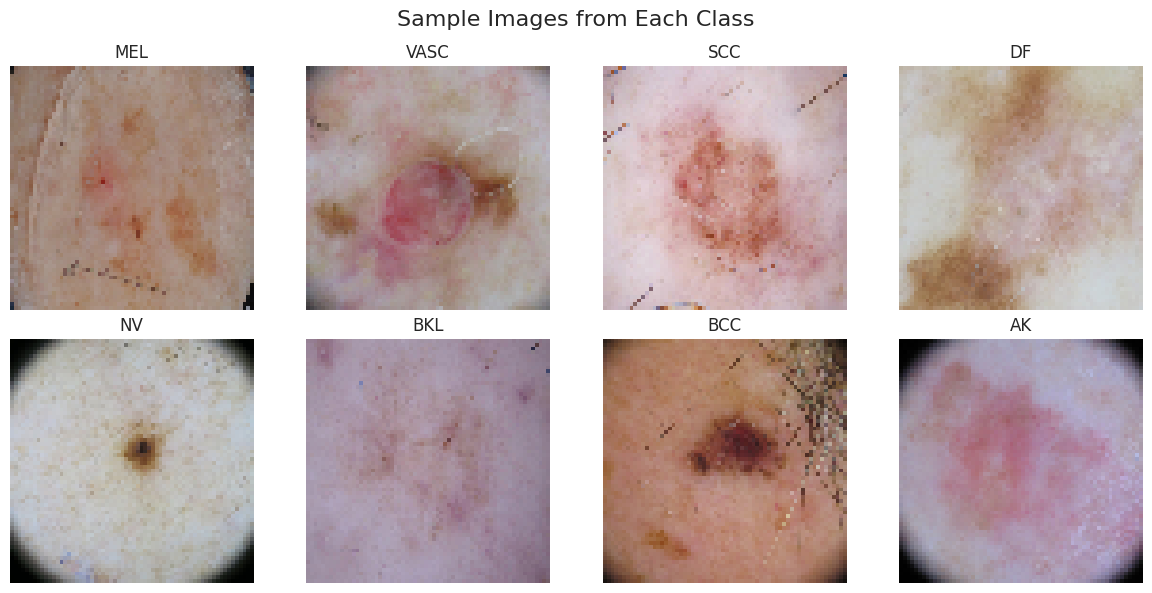

In [7]:
# Show sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i, class_name in enumerate(class_folders):
    class_folder_path = os.path.join(dataset_path, class_name)
    sample_img = load_img(os.path.join(class_folder_path, os.listdir(class_folder_path)[0]), target_size=(64, 64))
    axes[i].imshow(sample_img)
    axes[i].set_title(class_name)
    axes[i].axis("off")

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


## Class Distribution (Before Oversampling)

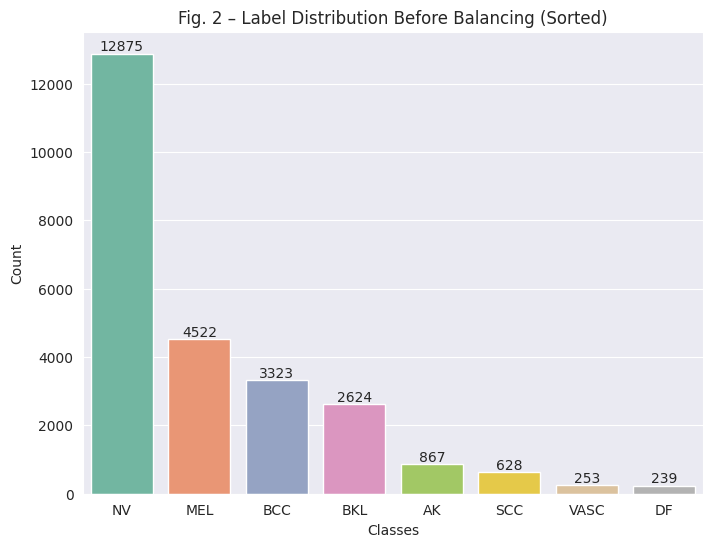

In [8]:
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

# Count of each class
class_counts = Counter(y_all)

# Sort classes by count descending
sorted_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=list(sorted_counts.keys()), y=list(sorted_counts.values()), palette="Set2")
plt.title("Fig. 2 – Label Distribution Before Balancing (Sorted)")
plt.xlabel("Classes")
plt.ylabel("Count")

# Add numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.show()


# 4. Data Preprocessing
## 4.1 Encode and Balance Data
Purpose: Convert labels to one-hot encoding and balance classes using oversampling.

In [9]:
from imblearn.over_sampling import RandomOverSampler

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_all)
y_one_hot = to_categorical(y_encoded)

# Reshape data for oversampling
X_reshaped = X_all.reshape(X_all.shape[0], -1)
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_one_hot)

print("Class distribution after oversampling:", Counter(np.argmax(y_resampled, axis=1)))

Class distribution after oversampling: Counter({4: 12875, 7: 12875, 6: 12875, 3: 12875, 5: 12875, 2: 12875, 1: 12875, 0: 12875})


## Class Distribution (After Oversampling)

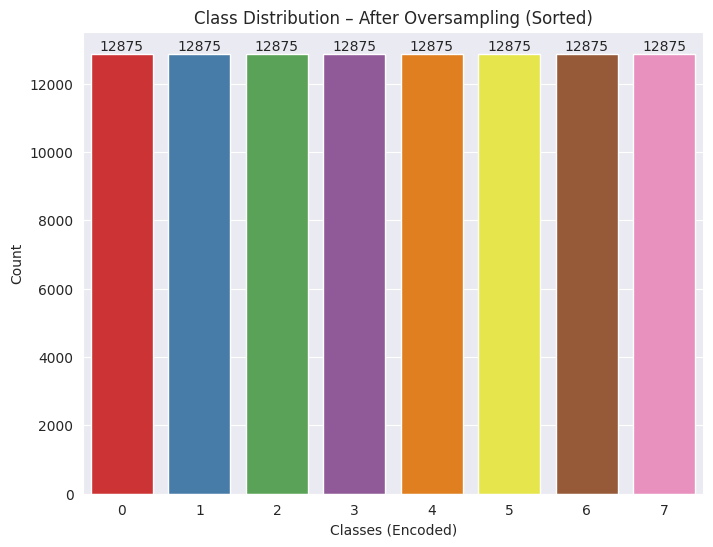

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Convert one-hot labels back to integer labels
y_res_labels = np.argmax(y_resampled, axis=1)

# Count and sort classes by descending frequency
class_counts_resampled = Counter(y_res_labels)
sorted_counts_resampled = dict(sorted(class_counts_resampled.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=list(sorted_counts_resampled.keys()), y=list(sorted_counts_resampled.values()), palette="Set1")
plt.title("Class Distribution – After Oversampling (Sorted)")
plt.xlabel("Classes (Encoded)")
plt.ylabel("Count")

# Add numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.show()


## 4.2 Split Data
Purpose: Create training and testing datasets

In [11]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

Shapes - X_train: (82400, 2352), X_test: (20600, 2352), y_train: (82400, 8), y_test: (20600, 8)


## 4.3 Reshape Data
Purpose: Restore original shape for model training.

In [12]:
# Reshape to (28, 28, 3)
X_train_reshaped = X_train.reshape(X_train.shape[0], 28, 28, 3)
X_test_reshaped = X_test.reshape(X_test.shape[0], 28, 28, 3)

# 5. Model Building
## 5.1 Define Model
Purpose: Create CNN architecture with L2 regularization to prevent overfitting.

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), 
           activation='relu', 
           padding='same', 
           kernel_initializer='he_normal', 
           kernel_regularizer=l2(0.01), 
           input_shape=(28, 28, 3)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, (3, 3), 
           activation='relu', 
           padding='same', 
           kernel_initializer='he_normal', 
           kernel_regularizer=l2(0.01)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, (3, 3), 
           activation='relu', 
           padding='same', 
           kernel_initializer='he_normal', 
           kernel_regularizer=l2(0.01)),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu', 
          kernel_initializer='he_normal', 
          kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(128, activation='relu', 
          kernel_initializer='he_normal', 
          kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(64, activation='relu', 
          kernel_initializer='he_normal', 
          kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(8, activation='softmax')
])

I0000 00:00:1755939378.261968      93 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


## 5.2 Compile Model
Purpose: Set optimizer, loss function, and evaluation metrics.

In [14]:
from tensorflow.keras.optimizers import Nadam

optimizer = Nadam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# 6. Model Training
Purpose: Train the CNN with callbacks for learning rate reduction and early stopping.

In [16]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=100, batch_size=128, callbacks=callbacks)

Epoch 1/100


2025-08-23 08:58:27.588772: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1755939516.289861     144 cuda_dnn.cc:529] Loaded cuDNN version 90300


642/644 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4144 - loss: 8.9551

2025-08-23 08:58:48.119681: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


644/644 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.4148 - loss: 8.9384 - val_accuracy: 0.4133 - val_loss: 2.7052 - learning_rate: 0.0010
Epoch 2/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6338 - loss: 1.9920 - val_accuracy: 0.6199 - val_loss: 1.8785 - learning_rate: 0.0010
Epoch 3/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6819 - loss: 1.7103 - val_accuracy: 0.6606 - val_loss: 1.7154 - learning_rate: 0.0010
Epoch 4/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7063 - loss: 1.6193 - val_accuracy: 0.6378 - val_loss: 1.7884 - learning_rate: 0.0010
Epoch 5/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7235 - loss: 1.5510 - val_accuracy: 0.7294 - val_loss: 1.5072 - learning_rate: 0.0010
Epoch 6/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7308 - loss: 1.5120 - val_accuracy: 0.7175 - val_loss: 1.5276 - learning_rate: 0.0010
Epoch 7/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7366 - loss: 1.4758

# 7. Evaluation
## 7.1 Plot Training Metrics
Purpose: Visualize training and validation accuracy/loss.

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting Training and Validation Metrics
def plot_training(hist):
    # Extracting accuracy and loss values
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    # Finding the best epochs for loss and accuracy
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Plot settings
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'Best Epoch = {index_loss + 1}'
    acc_label = f'Best Epoch = {index_acc + 1}'

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

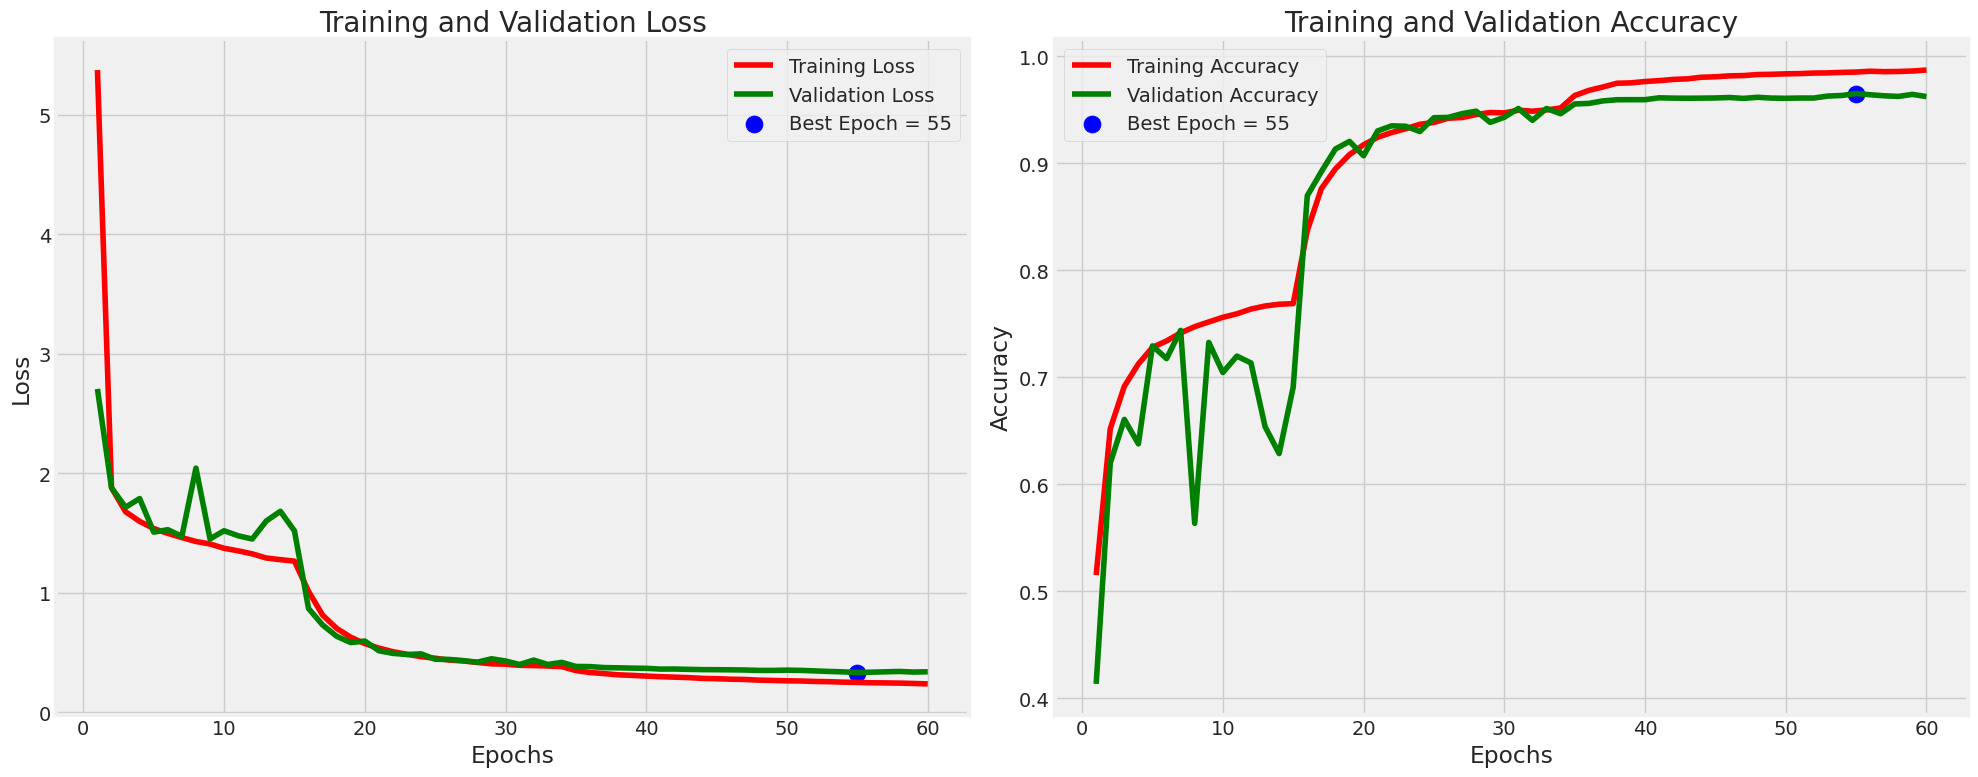

In [18]:
plot_training(history)

## 7.2 Test Performance
Purpose: Evaluate the model on test data

In [19]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

 48/644 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9594 - loss: 0.3639

2025-08-23 09:08:36.103622: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9647 - loss: 0.3383
Test Accuracy: 96.53%
Test Loss: 0.3326


## 7.3 Classification Report and Confusion Matrix
Purpose: Assess performance per class.

2025-08-23 09:08:47.967883: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

          AK       0.99      1.00      1.00      2582
         BCC       0.96      0.99      0.97      2665
         BKL       0.95      0.99      0.97      2582
          DF       1.00      1.00      1.00      2517
         MEL       0.90      0.93      0.92      2612
          NV       0.94      0.81      0.87      2557
         SCC       0.99      1.00      1.00      2550
        VASC       1.00      1.00      1.00      2535

    accuracy                           0.97     20600
   macro avg       0.97      0.97      0.96     20600
weighted avg       0.97      0.97      0.96     20600



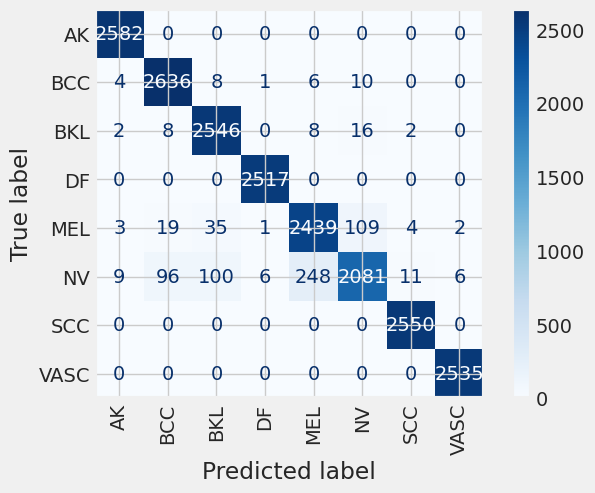

In [20]:
y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()

In [22]:
model.save("Imran_Roshan_Isic_Modle.h5")